# Stat-xplore statistics for Lewisham

Fetches labour market data

_This requires the `OA->LSOA` lookup table produced by `lbl_boundaries_oa.ipynb` as well as the `OA->WD22` lookup table produced by "`lbl_boundaries_2022_wards.ipynb`"_

# Setup

## Imports

In [1]:
%%capture
!pip install https://github.com/philipbrien/statxplorer/zipball/master
!pip install geopandas

In [2]:
import statxplorer
key = "65794a30655841694f694a4b563151694c434a68624763694f694a49557a49314e694a392e65794a7063334d694f694a7a644849756333526c6247786863694973496e4e3159694936496d6c7563326c6e614851745957356b4c57526c62476c325a584a355147786c64326c7a614746744c6d64766469353161794973496d6c68644349364d54597a4e7a497a4d6a51344d5377695958566b496a6f69633352794c6d396b59534a392e764b6a5355767a594132314a374a6a5f31345076774f6243584a6178576a52303173634e68547238517863"
import json
explorer = statxplorer.StatXplorer(key)


In [3]:
import os

import pandas as pd
import geopandas as gpd
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Filesystem

In [4]:
# Determine if in google colab
def in_colab():
    return True if os.getenv("HOME") == "/root" else False

In [5]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


Mounted at /content/gdrive
project_dir: /content/gdrive/MyDrive/WardProfiles


In [6]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

# For exports
output_dir = f"{project_dir}/income_support"

In [ ]:
!mkdir -p '{output_dir}'

In [ ]:
!ls '{output_dir}'

lbl_income_support_england11.csv    lbl_oa11_income_support.pdf
lbl_income_support_london11.csv     lbl_oa11_income_support.png
lbl_income_support_lsoa11.csv       table_2021-12-03_13-00-51.json
lbl_income_support_oa11.csv         table_2021-12-03_13-20-21.json
lbl_income_support_references11.csv table_2021-12-03_13-26-29.json
lbl_income_support_refs11.csv       table_2021-12-03_13-29-08.json
lbl_income_support_wd22.csv


Downloads
--

[Dataset: Income Support (IS)](https://stat-xplore.dwp.gov.uk/webapi/metadata/IS/Income%20Support.html)

```
Field: Default Summation

Income Support (IS) is intended to help cover costs for people on low incomes who do not have to be available for employment. It is being replaced by Universal Credit (UC) and IS cannot be claimed at the same time as UC.

The main groups of people who receive it are lone parents, carer’s and people on Incapacity Benefits.

The amount of IS that a claimant can receive depends mainly upon their age; whether they have a partner, whether they have special needs such as a disability or caring responsibilities; and whether they have liabilities for certain types of housing costs such as mortgage interest payments. The maximum amount that a claimant can receive is normally reduced by income from other types of benefits or other sources.

Recording and clerical errors can occur within the data source - for this reason, no reliance should be placed on very small numbers obtained through Stat-Xplore.

Statistical disclosure control has been applied with Stat-Xplore, which guards against the identification of an individual claimant. 
```

In [7]:
# get the data from the statxplore api

def get_data(table='table_2021-12-03_13-29-08'):
    query = f'{output_dir}/{table}.json'
    results = explorer.fetch_table(query, reshape=False)
    data = results['data']
    return data

df = get_data(table='table_2021-12-03_13-29-08')

In [8]:
df.head()

,National - Regional - LA - OAs,Quarter,Income Support
0,E00016403,May-19,6.0
1,E00016403,Aug-19,6.0
2,E00016403,Nov-19,6.0
3,E00016403,Feb-20,6.0
4,E00016403,May-20,6.0


## Functions to transform data

In [9]:
# epoch - list of matching time values (e.g. 'August 2021')
# lbl_oa_list - filter list of matching labels (e.g. England, London...)
def filter_statxplore_data(d, date_values, geography_values):  
  # use the `Quarter` and `National - Regional  - LA - OAs`
  return d[d['Quarter'].isin(date_values) &
           d['National - Regional - LA - OAs'].isin(geography_values)]

In [10]:
def format_statxplore_data(d, geo_colname):
  return d.\
           rename(columns={'National - Regional - LA - OAs': geo_colname})

In [11]:
# Convenience function to call the above two
def statxplore_to_oa(d, years, oa_list):
  return format_statxplore_data(filter_statxplore_data(d, years, oa_list),'OA11CD')

In [12]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, greater_group_table, oa_col, greater_col, group_col):
  return pd.merge(oa_data, greater_group_table, left_on=[oa_col], right_on=[greater_col], how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()


Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [13]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [14]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

Absolute numbers
--

In [15]:
epoch = ['May-21']
lbl_oa_list = oa_lsoa_join.OA11CD.unique()

for datname in ['income_support']:
  IPython.display.display(f"=== {datname} ===")

  # First process the Lewisham subset
  oas = filter_statxplore_data(df,epoch,lbl_oa_list)

  # Transform to OA index data
  lbl_oa = statxplore_to_oa(oas, epoch, lbl_oa_list)
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_lsoa_join, oa_col="OA11CD", greater_col='OA11CD', group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level  
  lbl_wd22 = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_wd22_join, oa_col="OA11CD", greater_col='OA11CD', group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Aggregate to London level  
  refs = filter_statxplore_data(df,epoch,['Lewisham','London','England'])
  refs = refs.rename(columns={'National - Regional - LA - OAs': 'Name'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.head())



'=== income_support ==='

,OA11CD,Quarter,Income Support
8,E00016403,May-21,0.0
17,E00016437,May-21,7.0
26,E00016439,May-21,5.0
35,E00016442,May-21,5.0
44,E00016399,May-21,0.0


,Income Support
LSOA11CD,
E01003189,31.0
E01003190,19.0
E01003191,11.0
E01003192,34.0
E01003193,13.0


,Income Support
WD22CD_proposed,
E05013714,153.0
E05013715,73.0
E05013716,47.0
E05013717,58.0
E05013718,27.0


,Name,Quarter,Income Support
7991,London,May-21,33775.0
8000,England,May-21,196026.0
8009,Lewisham,May-21,1700.0


Relative numbers
--

In [ ]:
# TODO: we need to get a population total to compute this
# Need to review StatXplore methodology to see what their population sample basis is

## Spatial

In [ ]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [ ]:
education_oa_geom = oa11.merge(lbl_oa, left_on='OA11CD', right_on='OA11CD')


# Output

No handles with labels found to put in legend.


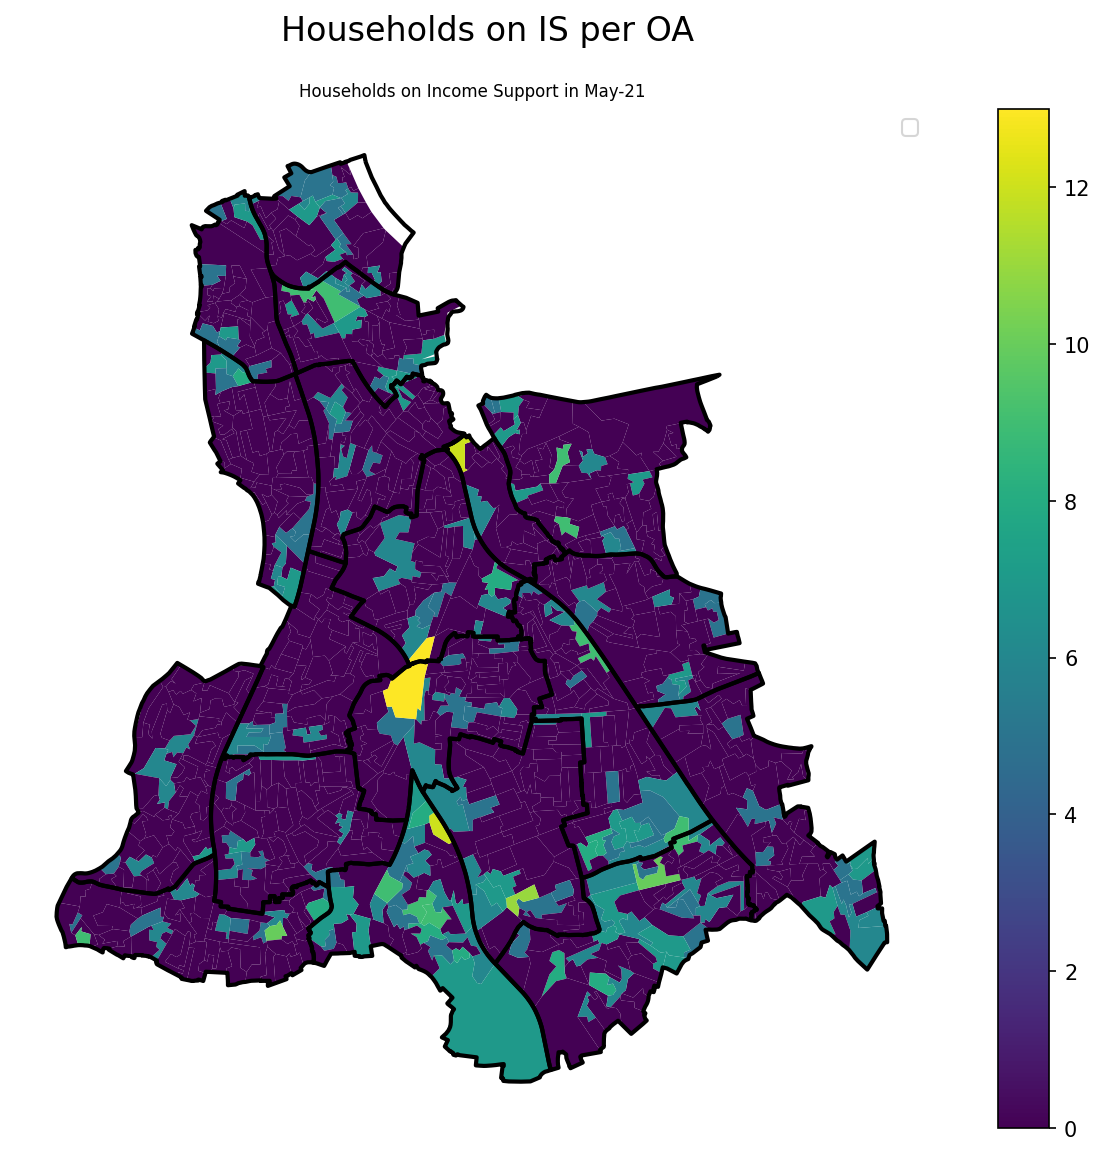

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Households on IS per OA', fontsize=16, y=.95)
plt.title('Households on Income Support in '+epoch[0], fontsize=8)
education_oa_geom.plot(ax=ax, column="Income Support", legend=True)
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

plt.axis('off')

plt.savefig(f"{output_dir}/lbl_oa11_income_support.png", dpi=600)
plt.savefig(f"{output_dir}/lbl_oa11_income_support.pdf")